# Prepocessing dataset

In [29]:
import os
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from collections import defaultdict
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch import device

from transformers import BertTokenizer

from src.preprocessor import balancing_multiple_classes
from src.bert.bert_functions import *

In [30]:
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth',None)

In [31]:
data_dir =  os.path.join(os.path.sep.join(os.getcwd().split(os.path.sep)[:-1]), "data")
models_dir =  os.path.join(os.path.sep.join(os.getcwd().split(os.path.sep)[:-1]), "models")

In [32]:
df_train = pd.read_csv(os.path.join(data_dir,"dataset.csv")).loc[lambda x: x["emotion"] != "neutral"]
df_test = pd.read_csv(os.path.join(data_dir,"test_set.csv"))

In [27]:
df_train.head(5)

,sentence,emotion
0,I just do not know i feel like i am just way to paranoid i want to trust but its hard been hurt way to many times .,fear
1,I want to be with him so bad that i feel i am being tortured right now .,anger
2,I spent most of the day alone and several hours feeling unimportant because we were going to hang out together but nothing happened .,sadness
3,I am feeling so horny that i will make love to you if you are here and let you shoot in me hoping that my egg and your sperm can unite .,happiness
4,I do love feeling all clever when i do understand what they are saying .,happiness


In [6]:
# Cleaning
df_train.drop_duplicates(keep='first',inplace=True)
df_train.dropna(inplace=True)
df_train["emotion"].value_counts()

emotion
happiness    224422
sadness      143454
anger         77918
fear          59695
surprise      35989
disgust        5550
Name: count, dtype: int64

In [8]:
df_balanced = balancing_multiple_classes(df_train,'emotion')
df_balanced['emotion'].value_counts()

emotion
happiness    5550
sadness      5550
anger        5550
fear         5550
surprise     5550
disgust      5550
Name: count, dtype: int64

In [7]:
emotion_dummies_train = pd.get_dummies(df_train['emotion'])
emotion_dummies_train = emotion_dummies_train.astype(int)

emotion_dummies_test = pd.get_dummies(df_test['emotion'])
emotion_dummies_test = emotion_dummies_test.astype(int)

In [8]:
df_train_main = pd.concat([df_train['sentence'], emotion_dummies_train], axis=1)
df_test_main = pd.concat([df_test['sentence'], emotion_dummies_test], axis=1)

df_test_main.head(4)

,sentence,anger,disgust,fear,happiness,sadness,surprise
0,Girls are happy when they get flowers,0,0,0,1,0,0
1,His jaw dropped in disbelief when he saw the price of the concert tickets.,0,0,0,0,0,1
2,Sometimes the ugly stench makes me wanna throw up.,0,1,0,0,0,0
3,The foul odor from the garbage bin was disgusting.,0,1,0,0,0,0


In [11]:
sample = df_train_main.sample(n = 1000, random_state = 4)
columns = sample.columns
freq = sample[columns[2:]].sum()/sample.shape[0]
freq

disgust      0.015
fear         0.116
happiness    0.394
sadness      0.265
surprise     0.063
dtype: float64

In [12]:
sample.head()

,sentence,anger,disgust,fear,happiness,sadness,surprise
528526,Well . . . perhaps you should think about it .,1,0,0,0,0,0
126699,Haha if only he had reddit,0,0,0,1,0,0
324090,i feel good and am gaining weight much better than i did with diego,0,0,0,1,0,0
482598,i am feeling a bit unsure of myself as i document the beautiful birth of my fourth child,0,0,1,0,0,0
502760,i feel so disgusted as i type this,1,0,0,0,0,0


# BERT Multi-class text classification

In [33]:
from src.bert.bert_model import BERTClassification
from src.bert.bert_tokenizer import TokenizedDataset

In [35]:
device: device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [10]:
training_df, validation_df = train_test_split(df_train_main, random_state=77, test_size=0.30, shuffle=True)
testing_df = df_test_main.copy()

In [11]:
print(f"Train: {training_df.shape}, Val: {validation_df.shape}, Test: {testing_df.shape}")

Train: (382919, 7), Val: (164109, 7), Test: (1436, 7)


In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [13]:
# test tokenizer on random sentence
test_text = training_df['sentence'].sample().iloc[0]

encodings = tokenizer.encode_plus(test_text, 
                                  add_special_tokens = True,
                                  max_length = 50,
                                  truncation = True,
                                  padding = "max_length", 
                                  return_attention_mask = True, 
                                  return_tensors = "pt")

print(f"original sentence: \n{test_text}\n")
print(f"tokenized sentence: \n{encodings}")

original sentence: 
I woke on saturday feeling a little brighter and was very keen to get outdoors after spending all day friday wallowing in self pity .

tokenized sentence: 
{'input_ids': tensor([[  101,  1045,  8271,  2006,  5095,  3110,  1037,  2210, 16176,  1998,
          2001,  2200, 10326,  2000,  2131, 19350,  2044,  5938,  2035,  2154,
          5958,  2813, 14138,  1999,  2969, 12063,  1012,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])}


In [14]:
emotion_list = emotion_dummies_train.columns.tolist()
emotion_list

['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise']

In [15]:
train_dataset = TokenizedDataset(training_df, tokenizer, MAX_LEN, emotion_list)
val_dataset = TokenizedDataset(validation_df, tokenizer, MAX_LEN, emotion_list)
test_dataset = TokenizedDataset(testing_df, tokenizer, MAX_LEN, emotion_list)

In [16]:
next(iter(test_dataset))

{'input_ids': tensor([ 101, 3057, 2024, 3407, 2043, 2027, 2131, 4870,  102,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0, 

In [17]:
# Data loaders
train_data_loader = torch.utils.data.DataLoader(train_dataset, 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(val_dataset, 
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

test_data_loader = torch.utils.data.DataLoader(test_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

In [18]:
num_labels = len(emotion_list)
model = BERTClassification(num_labels=num_labels)
model.to(device)

BERTClassification(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, 

# Model Training

In [ ]:
# Initialize a dictionary to store training and validation history
history = defaultdict(list)
best_accuracy = 0

# Loop over all epochs
for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}/{EPOCHS}')

    # Train the model
    model, train_acc, train_loss = train_model(train_data_loader, model, optimizer, loss_fn, device)
    val_acc, val_loss = eval_model(val_data_loader, model, optimizer, loss_fn, device)

    print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f} train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    # save the best model
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), os.path.join(models_dir, "bert_model.bin"))
        best_accuracy = val_acc

Epoch 1/5
Training:


  0%|          | 0/11967 [00:00<?, ?it/s]

Evaluating:


  0%|          | 0/5129 [00:00<?, ?it/s]

train_loss=0.0639, val_loss=0.0427 train_acc=0.9254, val_acc=0.9461
Epoch 2/5
Training:


  0%|          | 0/11967 [00:00<?, ?it/s]

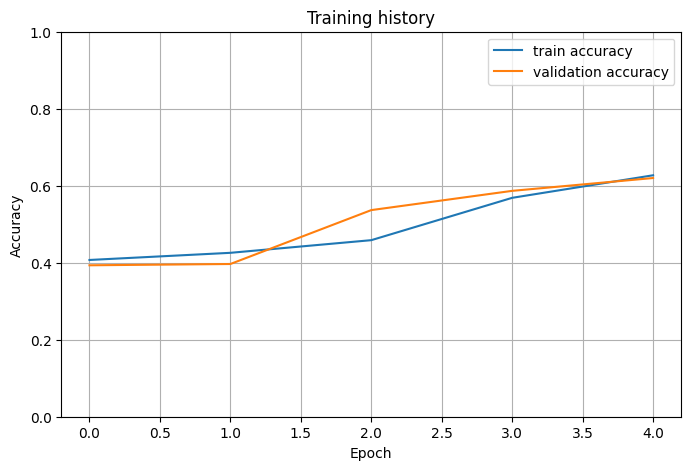

In [33]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.grid()

In [35]:
sentences, predictions, prediction_probs, emotion_values = get_predictions(model, test_data_loader, device)

In [ ]:
print(classification_report(emotion_values, predictions, target_names=emotion_list))

In [40]:
emotion_mapping = {'anger': 0, 'disgust': 1, 'fear': 2, 'happiness': 3, 'sadness': 4, 'surprise': 5}

predicted_emotions = [emotion for label in predictions for emotion, encoded_label in emotion_mapping.items() if label == encoded_label]

print('F1 score on test set: {}'.format(f1_score(df_test['emotion'], predicted_emotions, average='weighted')))

F1 score on test set: 0.25715768512540516
